# About
This notebook shows the ROC plot generation pipeline, and also contains current ROC plot development scripts.

# Imports and Setup

In [1]:
# lib
import sys

sys.path.append("..")

# set cwd one up
import os

os.chdir("..")
path = "data/hes/Hes1_example.csv"

os.getcwd()
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
from gpcell import plots
import numpy as np

from_start = True

### Setting up params

In [3]:
par1 = np.array([300, 1, 0.07, 0.07, 1, 1, 0], dtype=np.float64)
par2 = np.array([100, 3, 0.03, 0.03, 1, 1, 18], dtype=np.float64)
n_cells = 50  # total replicates used in the simulation
t_final_vals = [1500, 600]  # 25/10 hours
noise_vals = [np.sqrt(x) for x in [0.1, 0.5]]

sim_params = [[noise, t_final_vals[0], n_cells] for noise in noise_vals]
sim_params.append([noise_vals[0], t_final_vals[1], n_cells])

path = "data/matlab/"
paths = [
    path + f"noise_{round(noise**2, 2)}_time_{t_final}_rep_{n_cells}.csv"
    for noise, t_final, n_cells in sim_params
]


# Simulation

In [9]:
# from gpcell.utils import get_time_series

# --- generate data for plot --- #
# for path, (noise, t_final, n_cells) in zip(paths, sim_params):
#     get_time_series(par1, par2, t_final, noise, n_cells, path=path, mode="x")


# XY = [
#     utils.get_time_series(par1, par2, t_final, noise, n_cells, path=path, mode="x")
#     for path, (noise, t_final, n_cells) in zip(paths, sim_params)
# ]


# # save data
# for xy, path in zip(XY, paths):
#     utils.save_sim(xy[0], xy[1], path)


In [10]:
# from gpcell.backend import _simulate_replicate_mod9

# --------------------------------#
# --- test simulate functions --- #
# --------------------------------#

# --- test speed --- #
# %timeit XY = [utils.get_time_series(par1, par2, t_final, noise, n_cells) for noise, t_final, n_cells in sim_params]

# --- test load data --- #
# import pandas as pd
# df = pd.read_csv(paths[0])
# print(df.drop(columns="Time").shape[1])

# --- test simulate --- #
# X, Y = utils.get_time_series(par1, par2, t_final_vals[0], noise_vals[0], n_cells)
# print(len(X), len(Y))
# print(X[0].shape, Y[0].shape)

# Full run

In [11]:
# calculate ROC
fp1_vals, fp2_vals, tp1_vals, tp2_vals = [], [], [], []
for path, (noise, t_final, n_cells) in zip(paths, sim_params):
    fp1, tp1, fp2, tp2 = plots.compute_rocs_from_file(path, noise, n_cells, joblib=True)
    fp1_vals.append(fp1)
    tp1_vals.append(tp1)
    fp2_vals.append(fp2)
    tp2_vals.append(tp2)

FileNotFoundError: [Errno 2] No such file or directory: 'data/matlab/noise_0.1_time_1500_rep_200.csv'

In [ ]:
import matplotlib.pyplot as plt

# create 3 column horizontal figure
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
notes = [
    r"$\sigma^2=0.1$, 25 hours",
    r"$\sigma^2=0.5$, 25 hours",
    r"$\sigma^2=0.1$, 10 hours",
]

# plot ROC curves
for i, (fp1, tp1, fp2, tp2) in enumerate(zip(fp1_vals, tp1_vals, fp2_vals, tp2_vals)):
    plots.plot_roc(
        [fp1, fp2], [tp1, tp2], axes=axs[i], labels=["GP", "L-S"], note=notes[i]
    )

In [ ]:
import pandas as pd

# plot ROC
x_arr = []
dataNormed_arr = []

for path in paths:
    df = pd.read_csv(path)

    x = df["Time"].values
    dataNormed = df.drop(columns=["Time"]).values

    x_arr.append(x)
    dataNormed_arr.append(dataNormed)

plots.plot_rocs_and_timeseries(
    x_arr[0],
    dataNormed_arr[0],
    fp1_vals[0],
    tp1_vals[0],
    fp2_vals[0],
    tp2_vals[0],
    x_arr[1],
    dataNormed_arr[1],
    fp1_vals[1],
    tp1_vals[1],
    fp2_vals[1],
    tp2_vals[1],
    x_arr[2],
    dataNormed_arr[2],
    fp1_vals[2],
    tp1_vals[2],
    fp2_vals[2],
    tp2_vals[2],
    n_cells,
)

# ROC Dev

## Setup

In [ ]:
# --- Copy of start of document --- #

if "from_start" not in locals():
    print("Overwriting start")

    # lib
    import sys

    sys.path.append("..")

    # set cwd one up
    import os

    os.chdir("..")
    path = "data/hes/Hes1_example.csv"

    os.getcwd()
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

    from gpcell import plots
    import numpy as np

    par1 = np.array([300, 1, 0.07, 0.07, 1, 1, 0], dtype=np.float64)
    par2 = np.array([100, 3, 0.03, 0.03, 1, 1, 18], dtype=np.float64)
    n_cells = 1000  # total replicates used in the simulation
    t_final_vals = [1500, 600]  # 25/10 hours
    noise_vals = [np.sqrt(x) for x in [0.1, 0.5]]

    sim_params = [[noise, t_final_vals[0], n_cells] for noise in noise_vals]
    sim_params.append([noise_vals[0], t_final_vals[1], n_cells])

    path = "data/matlab/"
    paths = [
        path + f"noise_{round(noise**2, 2)}_time_{t_final}_rep_{n_cells}.csv"
        for noise, t_final, n_cells in sim_params
    ]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from gpcell.utils import get_time_series

# --- Function parameters --- #
filename = paths[0]
noise, t_final, n_cells = sim_params[0]
joblib = True


# ----------------------------#
# --- Function definition --- #
# ----------------------------#

# --- Read the generated data  --- #
# The CSV file is assumed to have a "Time" column (in hours) and then 2*n_cells columns for the simulated data.
x, y_list = get_time_series(
    par1, par2, t_final, noise, n_cells, path=filename, mode="r"
)
total_columns = len(y_list)

if total_columns != 2 * n_cells:
    raise ValueError(
        f"Expected 2*n_cells = {2 * n_cells} columns, but CSV has {total_columns} columns."
    )


Simulation data found at data/matlab/noise_0.1_time_1500_rep_50.csv, mode: r



## Logic

In [ ]:
from gpcell import OscillatorDetector
from gpcell.backend.priors import sim_ou_prior, sim_ouosc_prior

# --- Fit detector--- #
params = {
    "verbose": True,
    "joblib": joblib,
    "plots": ["BIC"],
    "set_noise": noise,
    "detrend": False,
    "ou_prior_gen": sim_ou_prior,
    "ouosc_prior_gen": sim_ouosc_prior,
}
od = OscillatorDetector.from_file(filename, "Time", "Cell", "Cell", params=params)
od.fit("BIC")
BICdiffM = od.BIC_diffs  # list or array with length equal to total_columns
BICdiffTOT = np.array(BICdiffM)


# --- ROC analysis using BIC differences --- #
# Split BIC differences into two groups: A (first n_cells) and B (next n_cells)
A = BICdiffTOT[:n_cells]
B = BICdiffTOT[n_cells : 2 * n_cells]
print(A.shape, B.shape)

# Define a threshold vector spanning a little below the min to a little above the max.
thresholds = np.linspace(BICdiffTOT.min() - 1, BICdiffTOT.max() + 1, 200)
FP1 = np.zeros_like(thresholds)
TP1 = np.zeros_like(thresholds)
for i, th in enumerate(thresholds):
    FP1[i] = np.sum(A > th)
    TP1[i] = np.sum(B > th)

# --- Plot BIC curve --- #
od.bic_plot

In [ ]:
thrvec = np.exp(np.linspace(-15, 0, 200))
n_thr = len(thrvec)
n_series = len(y_list)

# Preallocate a matrix to store detection results:
# rows: time series; columns: thresholds
beatmat = np.empty((n_series, n_thr), dtype=int)

# Loop once over all time series to compute their periodograms
for i, y in enumerate(y_list):
    ls = LombScargle(x, y)
    frequency, power = ls.autopower(normalization="standard")
    # For each threshold, compute false alarm level and determine detection
    for j, thr in enumerate(thrvec):
        pth = ls.false_alarm_level(thr)
        beatmat[i, j] = int(np.any(power > pth))

# Compute False Positives (FP) and True Positives (TP) vectorized over thresholds.
# Note: following the original code's convention:
#   - First half of y_list are considered oscillatory signals.
#   - Second half are non-oscillatory.
FP2 = (
    np.sum(beatmat[:n_cells, :], axis=0) / n_cells
)  # fraction detected among first half
TP2 = (
    np.sum(beatmat[n_cells:, :], axis=0) / n_cells
)  # fraction detected among second half


In [ ]:
plt.figure(figsize=(6, 4), dpi=150)  # Increase DPI for higher definition

# Plot lines with thinner width and possibly a z-order to be on top of grid
plt.plot(FP1 / n_cells, TP1 / n_cells, label="GP", lw=1, color="red", zorder=2)
plt.plot(FP2, TP2, label="L-S", lw=1, color="blue", zorder=2)

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], lw=1, linestyle="--", color="gray", zorder=1)

# Axis limits
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])

# Axis labels, title, legend
plt.xlabel("1 - Specificity (false positive rate)")
plt.ylabel("Sensitivity (true positive rate)")
plt.title("ROC Curve")
plt.legend(loc="lower right")

# If you have a grid, you can draw it behind the lines:
# plt.grid(True, zorder=0)

plt.tight_layout()  # Better spacing
plt.show()


### Test run

In [5]:
path, (noise, t_final, n_cells) = paths[0], sim_params[0]
FP1, TP1, FP2, TP2 = plots.compute_rocs_from_file(
    path, noise, n_cells, joblib=True, mcmc=True
)


Starting Oscillator Detector...

Overriding default value for verbose
Overriding default value for plots
Overriding default value for set_noise
Overriding default value for joblib
Overriding default value for ou_prior_gen
Overriding default value for ouosc_prior_gen

Loaded data with 100 cells, noise set to 0.31622776601683794
Plots: on

Fitting MCMC...

Homogenous traces: 100 cells, pre_dispatch: n_jobs, batch_size: auto


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  36 tasks      | elapsed:  3.2min
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:  8.7min finished


Unconstrained 1 r_hat: 1.1305458366305898, ess: 31.137092060150817
Unconstrained 2 r_hat: 1.057545109563227, ess: 77.39516862514385
Unconstrained 3 r_hat: 1.775694649013379, ess: 9.080762070535982
Unconstrained 4 r_hat: 1.467694136404941, ess: 11.970433977697372
Unconstrained 5 r_hat: 1.417114307927566, ess: 13.234596903140124
Unconstrained 6 r_hat: 1.7467494233108636, ess: 9.180936430707987
Unconstrained 7 r_hat: 1.737818019783176, ess: 9.385585811976517
Unconstrained 8 r_hat: 1.7849772583948205, ess: 8.94535878972726
Unconstrained 9 r_hat: 1.43795093678412, ess: 12.180448492285763
Unconstrained 10 r_hat: 1.8755080673212274, ess: 8.52432531585601
Unconstrained 11 r_hat: 1.6965683978414285, ess: 9.599690045407401
Unconstrained 12 r_hat: 1.7765933299219459, ess: 8.9241543369626
Unconstrained 13 r_hat: 1.9489699445975426, ess: 8.289411541747505
Unconstrained 14 r_hat: 1.667635101814043, ess: 9.653391268872893
Unconstrained 15 r_hat: 1.0742182517516654, ess: 184.81212681330067
Unconstrain

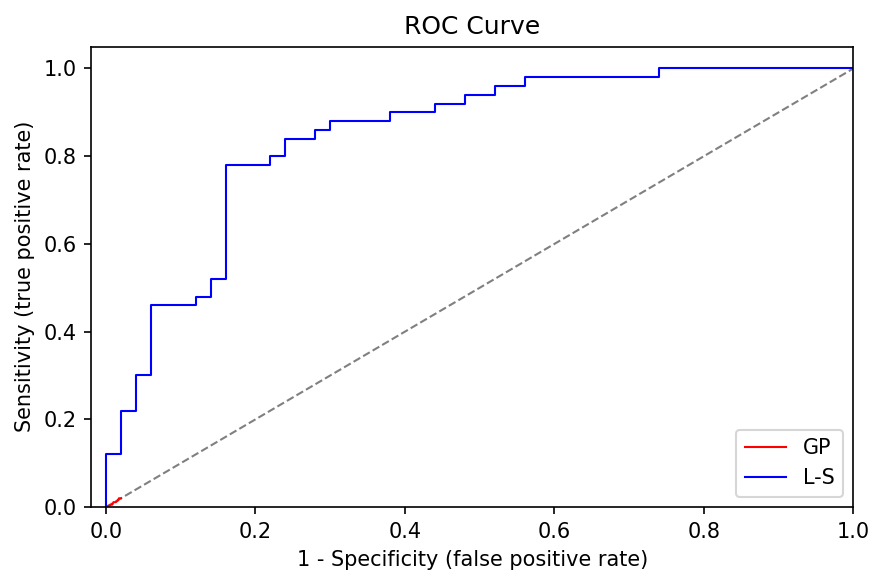

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4), dpi=150)  # Increase DPI for higher definition

# Plot lines with thinner width and possibly a z-order to be on top of grid
plt.plot(FP1 / n_cells, TP1 / n_cells, label="GP", lw=1, color="red", zorder=2)
plt.plot(FP2, TP2, label="L-S", lw=1, color="blue", zorder=2)

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], lw=1, linestyle="--", color="gray", zorder=1)

# Axis limits
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])

# Axis labels, title, legend
plt.xlabel("1 - Specificity (false positive rate)")
plt.ylabel("Sensitivity (true positive rate)")
plt.title("ROC Curve")
plt.legend(loc="lower right")

# If you have a grid, you can draw it behind the lines:
# plt.grid(True, zorder=0)

plt.tight_layout()  # Better spacing
plt.show()


In [ ]:
# --- Compute the Lomb-Scargle periodogram --- #
FP2, TP2 = plots.compute_LS_roc(x, y_list, n_cells)

# --- Plotting --- #
FP = [FP2]
TP = [TP2]

plots.plot_roc(FP, TP)

In [ ]:
import os
import time
import pickle
import shutil


class DiskBackedProxy:
    def __init__(self, index, directory):
        # Save metadata without triggering __setattr__
        self.__dict__["index"] = index
        self.__dict__["directory"] = directory
        self._load()

    def _load(self):
        filepath = os.path.join(self.directory, f"{self.__dict__['index']}.pkl")  # type: ignore
        try:
            with open(filepath, "rb") as f:
                self.__dict__["_obj"] = pickle.load(f)
        except (IOError, pickle.PickleError) as e:
            raise IOError(f"Error loading file {filepath}: {e}")

    def _save(self):
        filepath = os.path.join(self.directory, f"{self.__dict__['index']}.pkl")  # type: ignore
        try:
            with open(filepath, "wb") as f:
                pickle.dump(self.__dict__["_obj"], f)
        except (IOError, pickle.PickleError) as e:
            raise IOError(f"Error saving file {filepath}: {e}")

    def __getattr__(self, name):
        # Get attribute from the underlying object
        attr = getattr(self.__dict__["_obj"], name)
        # If the attribute is callable (e.g. a mutating method), wrap it
        if callable(attr):

            def wrapped(*args, **kwargs):
                result = attr(*args, **kwargs)
                self._save()
                return result

            return wrapped
        else:
            return attr

    def __setattr__(self, name, value):
        # Delegate attribute assignment to the underlying object
        setattr(self.__dict__["_obj"], name, value)
        self._save()

    def __getitem__(self, key):
        result = self.__dict__["_obj"][key]
        return result

    def __setitem__(self, key, value):
        self.__dict__["_obj"][key] = value
        self._save()

    def __iter__(self):
        # Check if the object is iterable
        if hasattr(self.__dict__["_obj"], "__iter__"):
            return iter(self.__dict__["_obj"])
        else:
            raise TypeError(f"{self.__dict__['_obj']} is not iterable")

    def __repr__(self):
        return repr(self.__dict__["_obj"])


class DiskBackedList:
    def __init__(self, objects, directory=None):
        # Use a default directory if none is provided.
        if directory is None:
            directory = "disk_backed_list"
        self.directory = directory
        os.makedirs(directory, exist_ok=True)
        self.length = len(objects)
        # Save each object as a separate pickle file
        for i, obj in enumerate(objects):
            filepath = os.path.join(directory, f"{i}.pkl")
            with open(filepath, "wb") as f:
                pickle.dump(obj, f)

    def __getitem__(self, index):
        if isinstance(index, int):
            if index < 0:
                index += self.length
            if index < 0 or index >= self.length:
                raise IndexError("Index out of range")
            return DiskBackedProxy(index, self.directory)
        elif isinstance(index, slice):
            indices = range(*index.indices(self.length))
            return [self.__getitem__(i) for i in indices]
        else:
            raise TypeError("Index must be an int or slice")

    def __iter__(self):
        for i in range(self.length):
            yield self[i]

    def __len__(self):
        return self.length

    def __repr__(self):
        return f"<DiskBackedList of length {self.length} stored in '{self.directory}'>"

    def __del__(self):
        # Destructor: delete the directory and all its files when this object is destroyed.
        try:
            shutil.rmtree(self.directory)
            print(f"Deleted directory {self.directory} and its contents.")
        except Exception as e:
            print(f"Error deleting directory {self.directory}: {e}")


def disk_backed_list(objects, directory=None):
    """
    Takes an iterable of Python objects, saves each to disk,
    and returns an indexable container whose items can be edited in place.
    """
    return DiskBackedList(objects, directory)


# Example usage:
if __name__ == "__main__":
    # For instance, using a list of dictionaries:
    objs = [{"a": 1}, {"b": 2}, {"c": 3}]

    start = time.process_time_ns()
    dbl = disk_backed_list(objs, directory="my_objects")
    end = time.process_time_ns()
    print(f"DiskBackedList created in {(end - start) / 1e9:.5f} seconds")

    # Access the second object (index 1)
    obj = dbl[1]
    print("Before modification:", obj)

    # Modify it in place; if the object is a dict, you can change it directly.
    obj["b"] = 999  # This triggers an automatic save.
    print("After modification:", dbl[1])

    del dbl
